# Analyzing Plato's Dialogues with Topic Modeling
## Iris Wu (iw5hte@virginia.edu) DS 5001 Spring 2023

## End goal of this notebook:
- Produce a table of document and topic concentrations.
- Produce a table of topics and term counts, either added to the VOCAB table or as a separate table with a shared index with the VOCAB table.
- Explore the data.

### Setting up necessary tools:
Importing useful packages -

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import plotly.express as px
import warnings
from hac import HAC
from graphviz import Graph
from scipy.spatial.distance import pdist
warnings.filterwarnings('ignore')

Setting up configurations (for data and functions):

In [2]:
data_in = 'data/output'
data_out = 'data/output'
data_prefix = 'plato'

In [3]:
ngram_range = [1,2]
n_terms = 4000
n_topics = 20
max_iter = 5
n_top_terms = 9

OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

weight_thresh = 0.2
corr_thresh = .1
nmi_thresh = .25

BAG = CHAP

TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

A function to make a topic model -

In [4]:
def make_topic_model(bag, phi_theta):
    
    count_engine_f = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
    count_model_f = count_engine_f.fit_transform(doc.doc_str)
    term = count_engine_f.get_feature_names_out()
    voc = pd.DataFrame(index=term)
    voc.index.name = 'term_str'
    dtm_f = pd.DataFrame(count_model_f.toarray(), index=doc.index, columns=term)
    lda_engine_f = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
    lda_model_f = lda_engine_f.fit_transform(count_model_f)
    theta_f = pd.DataFrame(lda_model_f, index=doc.index)
    if phi_theta == 'theta':
        theta_f.columns.name = 'topic_id'
        theta_f.columns = TNAMES
        return theta_f
    elif phi_theta == 'phi':
        phi_f = pd.DataFrame(lda_engine_f.components_, columns=term, index=TNAMES)
        phi_f.index.name = 'topic_id'
        phi_f.columns.name  = 'term_str'
        return phi_f

### Organizing Data

Getting the LIB and TOKEN tables -

In [5]:
LIB = pd.read_csv(f"{data_in}/{data_prefix}-LIB.csv").set_index(BOOK)
LIB

source_file_path       raw_title  \
book_id                                                   
1497       data/THE_REPUBLIC-pg1497.txt    THE REPUBLIC   
1571            data/CRITIAS-pg1571.txt         CRITIAS   
1572            data/TIMAEUS-pg1572.txt         TIMAEUS   
1579              data/LYSIS-pg1579.txt           LYSIS   
1580          data/CHARMIDES-pg1580.txt       CHARMIDES   
1584             data/LACHES-pg1584.txt          LACHES   
1591         data/PROTAGORAS-pg1591.txt      PROTAGORAS   
1598         data/EUTHYDEMUS-pg1598.txt      EUTHYDEMUS   
1600          data/SYMPOSIUM-pg1600.txt       SYMPOSIUM   
1616           data/CRATYLUS-pg1616.txt        CRATYLUS   
1635                data/ION-pg1635.txt             ION   
1636           data/PHAEDRUS-pg1636.txt        PHAEDRUS   
1642          data/EUTHYPHRO-pg1642.txt       EUTHYPHRO   
1643               data/MENO-pg1643.txt            MENO   
1656            data/APOLOGY-pg1656.txt         APOLOGY   
1657              data/CRITO-pg1657.txt           CRITO   
1658             data/PHAEDO-pg1658.txt          PHAEDO   
1672            data/GORGIAS-pg1672.txt         GORGIAS   
1673     data/LESSER_HIPPIAS-pg1673.txt  LESSER HIPPIAS   
1676       data/ALCIBIADES_I-pg1676.txt    ALCIBIADES I   
1677      data/ALCIBIADES_II-pg1677.txt   ALCIBIADES II   
1681            data/ERYXIAS-pg1681.txt         ERYXIAS   
1682          data/MENEXENUS-pg1682.txt       MENEXENUS   
1687         data/PARMENIDES-pg1687.txt      PARMENIDES   
1726         data/THEAETETUS-pg1726.txt      THEAETETUS   
1735            data/SOPHIST-pg1735.txt         SOPHIST   
1738          data/STATESMAN-pg1738.txt       STATESMAN   
1744           data/PHILEBUS-pg1744.txt        PHILEBUS   
1750               data/LAWS-pg1750.txt            LAWS   

                         chap_regex  book_len  n_chaps  
book_id                                                 
1497     ^\s*BOOK\s+[IVXLCM]+\.\s*$    118489       10  
1571       PERSONS OF THE DIALOGUE:      6789        1  
1572               ^Section\s+\d+.$     69903        8  
1579       PERSONS OF THE DIALOGUE:      9188        1  
1580       PERSONS OF THE DIALOGUE:     10750        1  
1584       PERSONS OF THE DIALOGUE:     10286        1  
1591       PERSONS OF THE DIALOGUE:     22995        1  
1598       PERSONS OF THE DIALOGUE:     15882        1  
1600       PERSONS OF THE DIALOGUE:     22248        1  
1616       PERSONS OF THE DIALOGUE:     23932        1  
1635       PERSONS OF THE DIALOGUE:      5177        1  
1636       PERSONS OF THE DIALOGUE:     23209        1  
1642       PERSONS OF THE DIALOGUE:      6793        1  
1643       PERSONS OF THE DIALOGUE:     12847        1  
1656                        APOLOGY     11404        1  
1657       PERSONS OF THE DIALOGUE:      5386        1  
1658       PERSONS OF THE DIALOGUE:     27512        1  
1672       PERSONS OF THE DIALOGUE:     35829        1  
1673       PERSONS OF THE DIALOGUE:      6048        1  
1676       PERSONS OF THE DIALOGUE:     14810        1  
1677       PERSONS OF THE DIALOGUE:      5529        1  
1681       PERSONS OF THE DIALOGUE:      6417        1  
1682       PERSONS OF THE DIALOGUE:      6581        1  
1687       PERSONS OF THE DIALOGUE:     18974        1  
1726       PERSONS OF THE DIALOGUE:     31453        1  
1735       PERSONS OF THE DIALOGUE:     22229        1  
1738       PERSONS OF THE DIALOGUE:     23615        1  
1744       PERSONS OF THE DIALOGUE:     23398        1  
1750     ^\s*BOOK\s+[IVXLCM]+\.\s*$    141128       12

In [6]:
TOKEN = pd.read_csv(f'{data_in}/{data_prefix}-CORPUS.csv')
TOKEN

book_id  chap_id  para_num  sent_num  token_num            pos_tuple  \
0          1497        1         1         0          0         ('I', 'PRP')   
1          1497        1         1         0          1      ('went', 'VBD')   
2          1497        1         1         0          2       ('down', 'RB')   
3          1497        1         1         0          3  ('yesterday', 'NN')   
4          1497        1         1         0          4         ('to', 'TO')   
...         ...      ...       ...       ...        ...                  ...   
738796     1750       12       127         0          5     ('EBook', 'NNP')   
738797     1750       12       127         0          6         ('of', 'IN')   
738798     1750       12       127         0          7     ('Laws,', 'NNP')   
738799     1750       12       127         0          8         ('by', 'IN')   
738800     1750       12       127         0          9     ('Plato', 'NNP')   

        pos  token_str   term_str pos_group  
0       PRP          I          i        PR  
1       VBD       went       went        VB  
2        RB       down       down        RB  
3        NN  yesterday  yesterday        NN  
4        TO         to         to        TO  
...     ...        ...        ...       ...  
738796  NNP      EBook      ebook        NN  
738797   IN         of         of        IN  
738798  NNP      Laws,       laws        NN  
738799   IN         by         by        IN  
738800  NNP      Plato      plato        NN  

[738801 rows x 10 columns]

Getting nouns into document -

In [7]:
doc = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

### Utilizing the topic model
Producing a phi table (how much a topic prefers a word)

In [8]:
PHI = make_topic_model(BAG, 'phi')
PHI

term_str   ability     abode    abroad    absence   absolute   abstain  \
topic_id                                                                 
T00       0.856458  1.050000  0.050000   0.050000   0.050000  0.050000   
T01       0.050000  0.050000  0.050000   0.050000   0.050000  0.050000   
T02       1.175085  0.050000  0.050000   0.050000   8.425435  2.050000   
T03       3.432286  0.050000  0.050000   2.327214  16.029994  0.050000   
T04       0.940515  5.049832  1.025036  13.669717  14.681872  0.056051   
T05       0.050000  0.050000  0.050000   1.050000   0.050000  0.050000   
T06       0.050000  0.050000  0.050000   0.050000   0.050000  0.050000   
T07       6.026398  0.050000  1.340917   0.050000   0.050000  1.593803   
T08       0.050000  0.050000  0.050000   0.050000   0.050000  0.050000   
T09       0.051902  0.050168  0.050000   0.050000   0.050000  0.050000   
T10       3.603579  1.050000  0.050000   9.767425   0.057127  1.240866   
T11       0.050000  0.050000  0.050000   0.050000   0.050000  0.050000   
T12       4.187421  0.050000  0.050000   0.050000   0.054171  0.050000   
T13       1.038621  0.050000  0.050000   1.050000   1.050000  0.050000   
T14       0.050000  0.050000  1.050000   0.050000   0.050000  0.050000   
T15       0.050000  0.050000  0.050000   3.421912   1.021109  0.050000   
T16       0.050000  0.050000  0.050000   0.050000   0.050000  0.050000   
T17       0.050000  0.050000  1.784047   0.050000   2.161715  3.309280   
T18       1.187735  0.050000  0.050000   1.063732   1.968576  0.050000   
T19       0.050000  0.050000  0.050000   0.050000   0.050000  0.050000   

term_str  abstract  abstraction  absurdity  abundance  ...  yesterday  \
topic_id                                               ...              
T00       0.050000     0.050000   0.050000   0.050000  ...   0.050000   
T01       0.050000     0.050000   0.050000   0.050000  ...   0.050000   
T02       0.050000     2.037194   1.169230   0.050000  ...   1.076949   
T03       2.501439     0.050000   4.702591   1.158808  ...   1.416187   
T04       0.050000     0.062870   1.060449   1.695220  ...   5.226629   
T05       0.050000     3.050000   0.050000   0.050000  ...   0.050000   
T06       0.050000     0.050000   0.050000   0.050000  ...   0.050000   
T07       0.050000     0.050000   0.050000   0.411966  ...   4.609024   
T08       0.050000     0.050000   0.050000   0.050000  ...   1.050000   
T09       0.050000     0.050000   0.050000   0.050000  ...   0.050000   
T10       0.050000     0.050000   3.294562   3.037357  ...   0.588601   
T11       0.050000     0.050000   0.050000   0.050000  ...   0.050000   
T12       0.975269     1.049936   1.214244   0.050000  ...   7.476651   
T13       2.255330     0.050000   1.035047   0.050000  ...   8.722580   
T14       0.050000     0.050000   0.050000   0.050000  ...   1.420372   
T15       0.050000     0.050000   0.050000   0.050000  ...   0.975991   
T16       0.050000     0.050000   0.050000   0.050000  ...   0.050000   
T17       3.023417     0.050000   1.950333   3.289118  ...   0.050000   
T18       3.494545     1.050000   2.973545   7.707529  ...   1.987016   
T19       0.050000     0.050000   0.050000   0.050000  ...   0.050000   

term_str      yoke     young   younger      youth  youth upwards    youths  \
topic_id                                                                     
T00       0.050000  4.819824  0.050000  22.581651       0.050021  0.050000   
T01       0.050000  0.050000  0.050000   0.050000       0.050000  0.050000   
T02       0.050000  0.050000  0.050000   4.616559       0.050000  1.050000   
T03       0.050000  0.050000  9.050000   5.136361       0.050000  0.050000   
T04       1.446887  1.973994  2.574886  82.207886       5.011527  2.940535   
T05       0.050000  0.050000  0.050000   0.050000       0.050000  0.050000   
T06       0.050000  0.050000  0.050000   0.050000       0.050000  0.050000   
T07       0.050000  5.474180  0.050000  17.269454       0.0500

Getting a table with entry and probability -

In [9]:
ww_sums = PHI.sum(axis=1)
total = ww_sums.sum()
ww_sums = ww_sums/total
vector = pd.DataFrame(ww_sums, columns=['p'])
vector['log_mle'] = np.log2(vector.p)
vector['mle_entropy'] = vector['p'] * -1 * vector['log_mle']
vector

p   log_mle  mle_entropy
topic_id                                 
T00       0.031931 -4.968908     0.158661
T01       0.001611 -9.277543     0.014949
T02       0.075284 -3.731518     0.280923
T03       0.066509 -3.910310     0.260070
T04       0.178881 -2.482925     0.444149
T05       0.008153 -6.938513     0.056567
T06       0.001611 -9.277543     0.014949
T07       0.084456 -3.565662     0.301140
T08       0.012937 -6.272405     0.081143
T09       0.047670 -4.390788     0.209307
T10       0.103101 -3.277864     0.337952
T11       0.001611 -9.277543     0.014949
T12       0.055481 -4.171857     0.231460
T13       0.097605 -3.356897     0.327651
T14       0.011188 -6.481915     0.072519
T15       0.033716 -4.890424     0.164885
T16       0.001611 -9.277543     0.014949
T17       0.113962 -3.133375     0.357086
T18       0.071070 -3.814606     0.271106
T19       0.001611 -9.277543     0.014949

In [10]:
vector_label = vector.sort_values('mle_entropy', ascending=False).reset_index()
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)
vector_label = vector_label.join(TOPICS['label'], on='topic_id')
vector_label

topic_id         p   log_mle  mle_entropy  \
0       T04  0.178881 -2.482925     0.444149   
1       T17  0.113962 -3.133375     0.357086   
2       T10  0.103101 -3.277864     0.337952   
3       T13  0.097605 -3.356897     0.327651   
4       T07  0.084456 -3.565662     0.301140   
5       T02  0.075284 -3.731518     0.280923   
6       T18  0.071070 -3.814606     0.271106   
7       T03  0.066509 -3.910310     0.260070   
8       T12  0.055481 -4.171857     0.231460   
9       T09  0.047670 -4.390788     0.209307   
10      T15  0.033716 -4.890424     0.164885   
11      T00  0.031931 -4.968908     0.158661   
12      T08  0.012937 -6.272405     0.081143   
13      T14  0.011188 -6.481915     0.072519   
14      T05  0.008153 -6.938513     0.056567   
15      T11  0.001611 -9.277543     0.014949   
16      T01  0.001611 -9.277543     0.014949   
17      T16  0.001611 -9.277543     0.014949   
18      T06  0.001611 -9.277543     0.014949   
19      T19  0.001611 -9.277543     0.014949   

                                                label  
0   T04 yes, man, men, knowledge, things, way, tru...  
1   T17 law, man, state, city, men, laws, place, t...  
2   T10 things, men, man, art, soul, nature, state...  
3   T13 body, air, nature, earth, soul, world, thi...  
4   T07 man, virtue, men, knowledge, justice, thin...  
5   T02 soul, body, man, life, things, nature, dea...  
6   T18 things, names, word, man, thing, meaning, ...  
7   T03 pleasure, things, true, pleasures, time, p...  
8   T12 love, lover, man, men, art, nature, gods, ...  
9   T09 man, art, justice, injustice, men, rhetori...  
10  T15 art, science, arts, knowledge, class, true...  
11  T00 men, man, life, death, truth, gods, pleasu...  
12  T08 friend, yes, good, friendship, evil, love,...  
13  T14 men, war, city, sea, barbarians, children,...  
14  T05 nature, world, ideas, mind, philosopher, p...  
15  T11 taste, eye ear, reach, strike, ability, pr...  
16  T01 taste, eye ear, reach, strike, ability, pr...  
17  T16 taste, eye ear, reach, strike, ability, pr...  
18  T06 taste, eye ear, reach, strike, ability, pr...  
19  T19 taste, eye ear, reach, strike, ability, pr...

What are the words that constitute each topic?

In [11]:
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])
TOPICS

term_str         0        1        2           3            4           5  \
topic_id                                                                    
T00            men      man     life       death        truth        gods   
T01          taste  eye ear    reach      strike      ability      praise   
T02           soul     body      man        life       things      nature   
T03       pleasure   things     true   pleasures         time       parts   
T04            yes      man      men   knowledge       things         way   
T05         nature    world    ideas        mind  philosopher  philosophy   
T06          taste  eye ear    reach      strike      ability      praise   
T07            man   virtue      men   knowledge      justice      things   
T08         friend      yes     good  friendship         evil        love   
T09            man      art  justice   injustice          men    rhetoric   
T10         things      men      man         art         soul      nature   
T11          taste  eye ear    reach      strike      ability      praise   
T12           love    lover      man         men          art      nature   
T13           body      air   nature       earth         soul       world   
T14            men      war     city         sea   barbarians    children   
T15            art  science     arts   knowledge        class        true   
T16          taste  eye ear    reach      strike      ability      praise   
T17            law      man    state        city          men        laws   
T18         things    names     word         man        thing     meaning   
T19          taste  eye ear    reach      strike      ability      praise   

term_str          6                 7              8  
topic_id                                              
T00        pleasure               way          music  
T01            pray  praises censures        praises  
T02           death              time            way  
T03          nature         certainly            yes  
T04            true              sort         nature  
T05       influence         knowledge      principle  
T06            pray  praises censures        praises  
T07             art          question        opinion  
T08           lover               son  friend friend  
T09            evil              good         friend  
T10           state              life            way  
T11            pray  praises censures        praises  
T12            gods            beauty         speech  
T13          things             water         reason  
T14         fathers              king        country  
T15             man              king         things  
T16            pray  praises censures        praises  
T17           place            things            way  
T18          motion           letters          truth  
T19            pray  praises censures        praises

Producing a theta table (how much a document prefers a topic)

In [12]:
THETA = make_topic_model(BAG, 'theta')
THETA

T00       T01       T02       T03       T04       T05  \
book_id chap_id                                                               
1497    1        0.000025  0.000025  0.000025  0.000025  0.223645  0.000025   
        2        0.000027  0.000027  0.167193  0.000027  0.279994  0.000027   
        3        0.149668  0.000021  0.088251  0.000021  0.761720  0.000021   
        4        0.000025  0.000025  0.000025  0.000025  0.999516  0.000025   
        5        0.000021  0.000021  0.000021  0.000021  0.831147  0.000021   
        6        0.000026  0.000026  0.142614  0.089176  0.662469  0.000026   
        7        0.000026  0.000026  0.093500  0.000026  0.596322  0.000026   
        8        0.000026  0.000026  0.000026  0.000026  0.999513  0.000026   
        9        0.000029  0.000029  0.137691  0.130940  0.730872  0.000029   
        10       0.000025  0.000025  0.853269  0.000025  0.146281  0.000025   
1571    1        0.000040  0.000040  0.000040  0.000040  0.000040  0.000040   
1572    1        0.000018  0.000018  0.000018  0.000018  0.000018  0.000018   
        2        0.000065  0.000065  0.000065  0.000065  0.000065  0.998771   
        3        0.000049  0.000049  0.000049  0.026539  0.000049  0.039474   
        4        0.000118  0.000118  0.000118  0.000118  0.000118  0.000118   
        5        0.000223  0.000223  0.468339  0.000223  0.000223  0.000223   
        6        0.000163  0.000163  0.000163  0.000163  0.000163  0.000163   
        7        0.000303  0.000303  0.010476  0.000303  0.000303  0.000303   
        8        0.000007  0.000007  0.033492  0.000007  0.000007  0.000007   
1579    1        0.000037  0.000037  0.000037  0.000037  0.000037  0.000037   
1580    1        0.000029  0.000029  0.000029  0.000029  0.993707  0.000029   
1584    1        0.000033  0.000033  0.000033  0.000033  0.000033  0.000033   
1591    1        0.000014  0.000014  0.000014  0.089852  0.148405  0.000014   
1598    1        0.000023  0.000023  0.000023  0.000023  0.617489  0.000023   
1600    1        0.000014  0.000014  0.000014  0.000014  0.011475  0.000014   
1616    1        0.000014  0.000014  0.000014  0.000014  0.000014  0.000014   
1635    1        0.000066  0.000066  0.000066  0.000066  0.000066  0.000066   
1636    1        0.000013  0.000013  0.277037  0.000013  0.000013  0.000013   
1642    1        0.000051  0.000051  0.000051  0.000051  0.000051  0.000051   
1643    1        0.000026  0.000026  0.000026  0.000026  0.000026  0.000026   
1656    1        0.999397  0.000032  0.000032  0.000032  0.000032  0.000032   
1657    1        0.998690  0.000069  0.000069  0.000069  0.000069  0.000069   
1658    1        0.000011  0.000011  0.999789  0.000011  0.000011  0.000011   
1672    1        0.000009  0.000009  0.000009  0.000009  0.000009  0.000009   
1673    1        0.000065  0.000065  0.000065  0.000065  0.000065  0.000065   
1676    1        0.000025  0.000025  0.000025  0.000025  0.000025  0.000025   
1677    1        0.000069  0.000069  0.000069  0.000069  0.000069  0.000069   
1681    1        0.000052  0.000052  0.000052  0.000052  0.000052  0.000052   
1682    1        0.000048  0.000048  0.000048  0.000048  0.000048  0.000048   
1687    1        0.000021  0.000021  0.000021  0.999605  0.000021  0.000021   
1726    1        0.000011  0.000011  0.000011  0.155728  0.018125  0.000011   
1735    1        0.000015  0.000015  0.000015  0.148923  0.000015  0.000015   
1738    1        0.000013  0.000013  0.000013  0.000013  0.000013  0.000013   
1744    1        0.000013  0.000013  0.000013  0.999759  0.000013  0.000013   
1750    1        0.000028  0.000028  0.000028  0.000028  0.552402  0.000028   
        2        0.623944  0.000032  0.000032  0.000032  0.340197  0.000032   
        3        0.000027  0.000027  0.000027  0.000027  0.922264  0.000027   
        4        0.000033  0.000033  0.000033  0.000033  0.523556  0.000033   
        5        0.000027  0.000027  0.000027  0.000027  0.000027  0.000

### Quantifying and visualizing topic weight

In [13]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
TOPICS

term_str         0        1        2           3            4           5  \
topic_id                                                                    
T00            men      man     life       death        truth        gods   
T01          taste  eye ear    reach      strike      ability      praise   
T02           soul     body      man        life       things      nature   
T03       pleasure   things     true   pleasures         time       parts   
T04            yes      man      men   knowledge       things         way   
T05         nature    world    ideas        mind  philosopher  philosophy   
T06          taste  eye ear    reach      strike      ability      praise   
T07            man   virtue      men   knowledge      justice      things   
T08         friend      yes     good  friendship         evil        love   
T09            man      art  justice   injustice          men    rhetoric   
T10         things      men      man         art         soul      nature   
T11          taste  eye ear    reach      strike      ability      praise   
T12           love    lover      man         men          art      nature   
T13           body      air   nature       earth         soul       world   
T14            men      war     city         sea   barbarians    children   
T15            art  science     arts   knowledge        class        true   
T16          taste  eye ear    reach      strike      ability      praise   
T17            law      man    state        city          men        laws   
T18         things    names     word         man        thing     meaning   
T19          taste  eye ear    reach      strike      ability      praise   

term_str          6                 7              8  doc_weight_sum  \
topic_id                                                               
T00        pleasure               way          music        2.848789   
T01            pray  praises censures        praises        0.002306   
T02           death              time            way        3.440318   
T03          nature         certainly            yes        2.642650   
T04            true              sort         nature       11.018453   
T05       influence         knowledge      principle        1.040438   
T06            pray  praises censures        praises        0.002306   
T07             art          question        opinion        5.775414   
T08           lover               son  friend friend        1.051606   
T09            evil              good         friend        1.677250   
T10           state              life            way        5.579292   
T11            pray  praises censures        praises        0.002306   
T12            gods            beauty         speech        2.025028   
T13          things             water         reason        6.248826   
T14         fathers              king        country        1.151719   
T15             man              king         things        1.828912   
T16            pray  praises censures        praises        0.002306   
T17           place            things            way        5.883237   
T18          motion           letters          truth        3.776538   
T19            pray  praises censures        praises        0.002306   

term_str                                              label  term_freq  
topic_id                                                                
T00       T00 men, man, life, death, truth, gods, pleasu...   0.031931  
T01       T01 taste, eye ear, reach, strike, ability, pr...   0.001611  
T02       T02 soul, body, man, life, things, nature, dea...   0.075284  
T03       T03 pleasure, things, true, pleasures, time, p...   0.066509  
T04       T04 yes, man, men, knowledge, things, way, tru...   0.178881  
T05       T05 nature, world, ideas, mind, philosopher, p...   0.008153  
T06       T06 taste, eye ear, reach, strike, ability, pr...   0.001611  
T07       T07 man, virtue, men, knowledge, justice, thin...   0

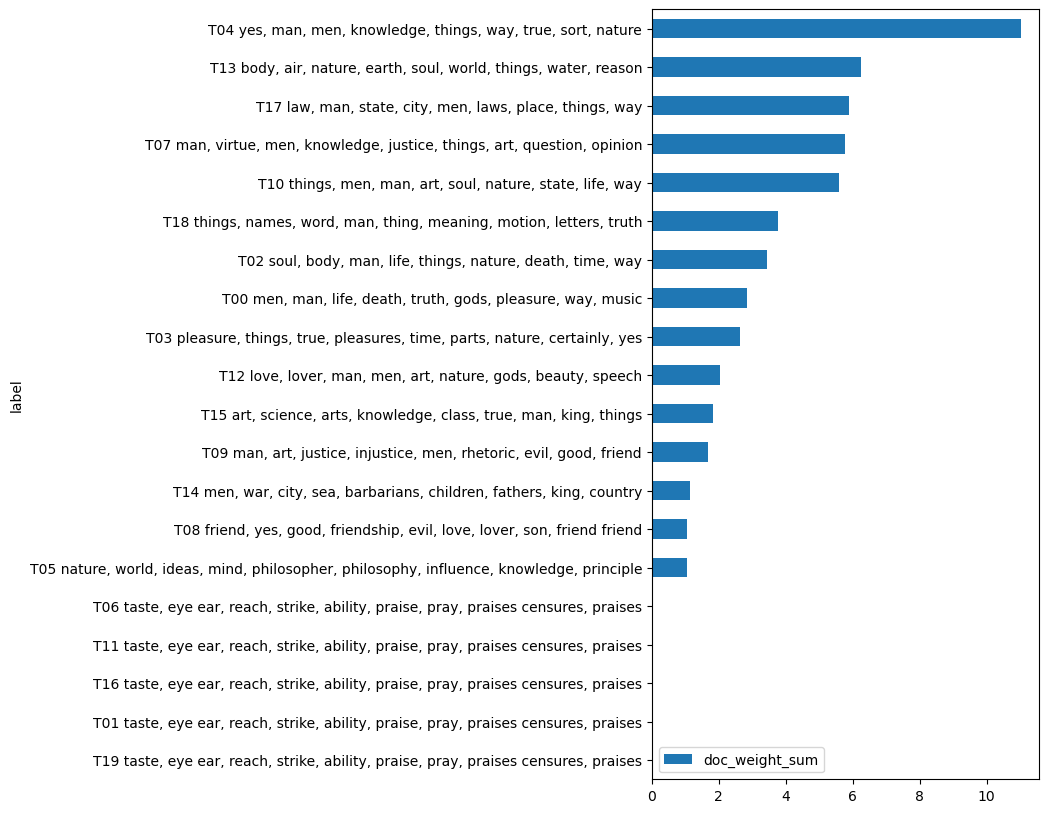

In [14]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5, n_topics/2));

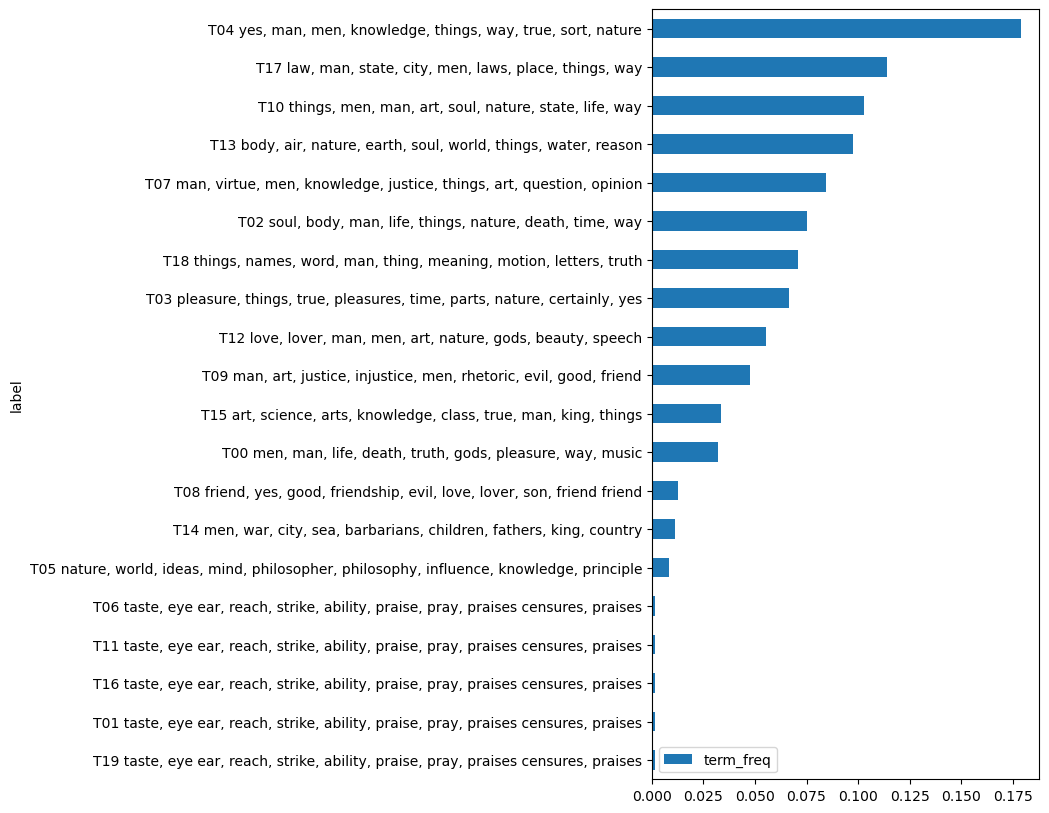

In [15]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='label', figsize=(5,n_topics/2));

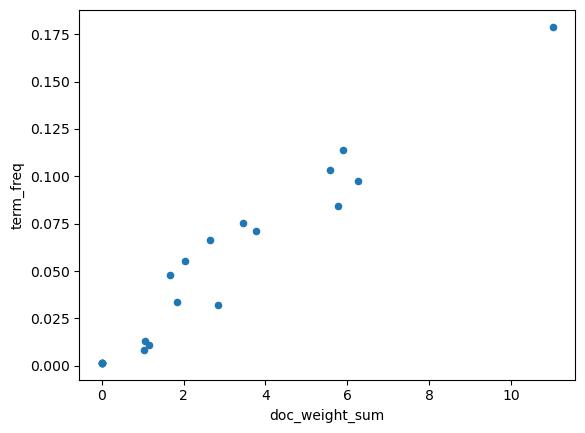

In [16]:
TOPICS.plot.scatter('doc_weight_sum', 'term_freq');

### Relating texts to topics
Adding information about the topics and the dialogues: which topics are most associated with The Republic, for instance?

In [17]:
TITLES = sorted(LIB.raw_title.value_counts().index.to_list())
TOPICS[TITLES] = THETA.join(LIB, on='book_id').groupby('raw_title')[TNAMES].mean().T
TOPICS.sort_values('THE REPUBLIC', ascending=False)

term_str         0        1        2           3            4           5  \
topic_id                                                                    
T04            yes      man      men   knowledge       things         way   
T02           soul     body      man        life       things      nature   
T09            man      art  justice   injustice          men    rhetoric   
T07            man   virtue      men   knowledge      justice      things   
T18         things    names     word         man        thing     meaning   
T03       pleasure   things     true   pleasures         time       parts   
T00            men      man     life       death        truth        gods   
T10         things      men      man         art         soul      nature   
T17            law      man    state        city          men        laws   
T13           body      air   nature       earth         soul       world   
T12           love    lover      man         men          art      nature   
T15            art  science     arts   knowledge        class        true   
T08         friend      yes     good  friendship         evil        love   
T05         nature    world    ideas        mind  philosopher  philosophy   
T14            men      war     city         sea   barbarians    children   
T06          taste  eye ear    reach      strike      ability      praise   
T01          taste  eye ear    reach      strike      ability      praise   
T11          taste  eye ear    reach      strike      ability      praise   
T16          taste  eye ear    reach      strike      ability      praise   
T19          taste  eye ear    reach      strike      ability      praise   

term_str          6                 7              8  doc_weight_sum  ...  \
topic_id                                                              ...   
T04            true              sort         nature       11.018453  ...   
T02           death              time            way        3.440318  ...   
T09            evil              good         friend        1.677250  ...   
T07             art          question        opinion        5.775414  ...   
T18          motion           letters          truth        3.776538  ...   
T03          nature         certainly            yes        2.642650  ...   
T00        pleasure               way          music        2.848789  ...   
T10           state              life            way        5.579292  ...   
T17           place            things            way        5.883237  ...   
T13          things             water         reason        6.248826  ...   
T12            gods            beauty         speech        2.025028  ...   
T15             man              king         things        1.828912  ...   
T08           lover               son  friend friend        1.051606  ...   
T05       influence         knowledge      principle        1.040438  ...   
T14         fathers              king        country        1.151719  ...   
T06            pray  praises censures        praises        0.002306  ...   
T01            pray  praises censures        praises        0.002306  ...   
T11            pray  praises censures        praises        0.002306  ...   
T16            pray  praises censures        praises        0.002306  ...   
T19            pray  praises censures        praises        0.002306  ...   

term_str    PHAEDO  PHAEDRUS  PHILEBUS  PROTAGORAS   SOPHIST  STATESMAN  \
topic_id                                                                  
T04       0.000011  0.000013  0.000013    0.148405  0.000015   0.000013   
T02       0.999789  0.277037  0.000013    0.000014  0.000015   0.000013   
T09       0.000011  0.000013  0.000013    0.000014  0.000015   0.000013   
T07       0.000011  0.000013  0.000013    0.697005  0.000015   0.000013   
T18       0.000011  0.000013  0.000013    0.058482  0.078863   0.012951   
T03       0.000011  0.000013  0.999759    0.089852  0.148923   0.000013   
T00       

Which dialogue is most associated with a particular topic?

In [18]:
book_means = THETA.groupby(['book_id']).mean()
book_means.sort_values('T10', ascending = False)['T10']

book_id
1677    0.917673
1735    0.755871
1676    0.655438
1750    0.230405
1672    0.209737
1738    0.158889
1497    0.010555
1681    0.009708
1572    0.000118
1657    0.000069
1635    0.000066
1673    0.000065
1642    0.000051
1682    0.000048
1571    0.000040
1579    0.000037
1584    0.000033
1656    0.000032
1580    0.000029
1643    0.000026
1598    0.000023
1687    0.000021
1600    0.000014
1591    0.000014
1616    0.000014
1636    0.000013
1744    0.000013
1658    0.000011
1726    0.000011
Name: T10, dtype: float64

Assigning the most probable dialogue to each topic -

In [19]:
TOPICS['title'] = TOPICS[TITLES].idxmax(1)
TOPICS.iloc[:,n_top_terms:].sort_values(['title','doc_weight_sum'], ascending=[True,False])
TOPICS

term_str         0        1        2           3            4           5  \
topic_id                                                                    
T00            men      man     life       death        truth        gods   
T01          taste  eye ear    reach      strike      ability      praise   
T02           soul     body      man        life       things      nature   
T03       pleasure   things     true   pleasures         time       parts   
T04            yes      man      men   knowledge       things         way   
T05         nature    world    ideas        mind  philosopher  philosophy   
T06          taste  eye ear    reach      strike      ability      praise   
T07            man   virtue      men   knowledge      justice      things   
T08         friend      yes     good  friendship         evil        love   
T09            man      art  justice   injustice          men    rhetoric   
T10         things      men      man         art         soul      nature   
T11          taste  eye ear    reach      strike      ability      praise   
T12           love    lover      man         men          art      nature   
T13           body      air   nature       earth         soul       world   
T14            men      war     city         sea   barbarians    children   
T15            art  science     arts   knowledge        class        true   
T16          taste  eye ear    reach      strike      ability      praise   
T17            law      man    state        city          men        laws   
T18         things    names     word         man        thing     meaning   
T19          taste  eye ear    reach      strike      ability      praise   

term_str          6                 7              8  doc_weight_sum  ...  \
topic_id                                                              ...   
T00        pleasure               way          music        2.848789  ...   
T01            pray  praises censures        praises        0.002306  ...   
T02           death              time            way        3.440318  ...   
T03          nature         certainly            yes        2.642650  ...   
T04            true              sort         nature       11.018453  ...   
T05       influence         knowledge      principle        1.040438  ...   
T06            pray  praises censures        praises        0.002306  ...   
T07             art          question        opinion        5.775414  ...   
T08           lover               son  friend friend        1.051606  ...   
T09            evil              good         friend        1.677250  ...   
T10           state              life            way        5.579292  ...   
T11            pray  praises censures        praises        0.002306  ...   
T12            gods            beauty         speech        2.025028  ...   
T13          things             water         reason        6.248826  ...   
T14         fathers              king        country        1.151719  ...   
T15             man              king         things        1.828912  ...   
T16            pray  praises censures        praises        0.002306  ...   
T17           place            things            way        5.883237  ...   
T18          motion           letters          truth        3.776538  ...   
T19            pray  praises censures        praises        0.002306  ...   

term_str  PHAEDRUS  PHILEBUS  PROTAGORAS   SOPHIST  STATESMAN  SYMPOSIUM  \
topic_id                                                                   
T00       0.000013  0.000013    0.000014  0.000015   0.000013   0.000014   
T01       0.000013  0.000013    0.000014  0.000015   0.000013   0.000014   
T02       0.277037  0.000013    0.000014  0.000015   0.000013   0.000014   
T03       0.000013  0.999759    0.089852  0.148923   0.000013   0.000014   
T04       0.000013  0.000013    0.148405  0.000015   0.000013   0.011475   
T05       0.000013  0.000013    0.000014  0.000015   0.000013   0.000014   
T0

### Visualizing relationships between topics

<Figure size 640x480 with 0 Axes>

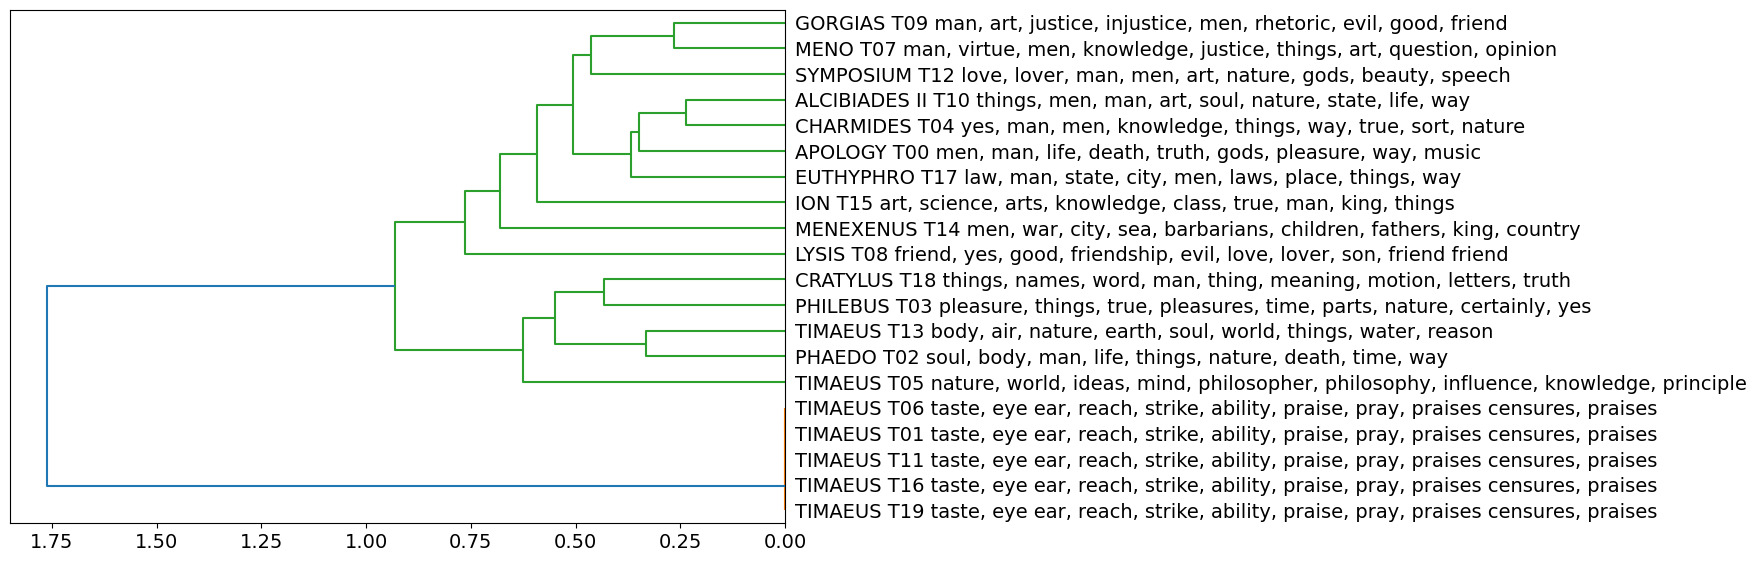

In [20]:
labels  = [f"{a.upper()} {b}" for a, b in zip(TOPICS.title, TOPICS.label)]
HAC(PHI, labels=labels).plot();

<Figure size 640x480 with 0 Axes>

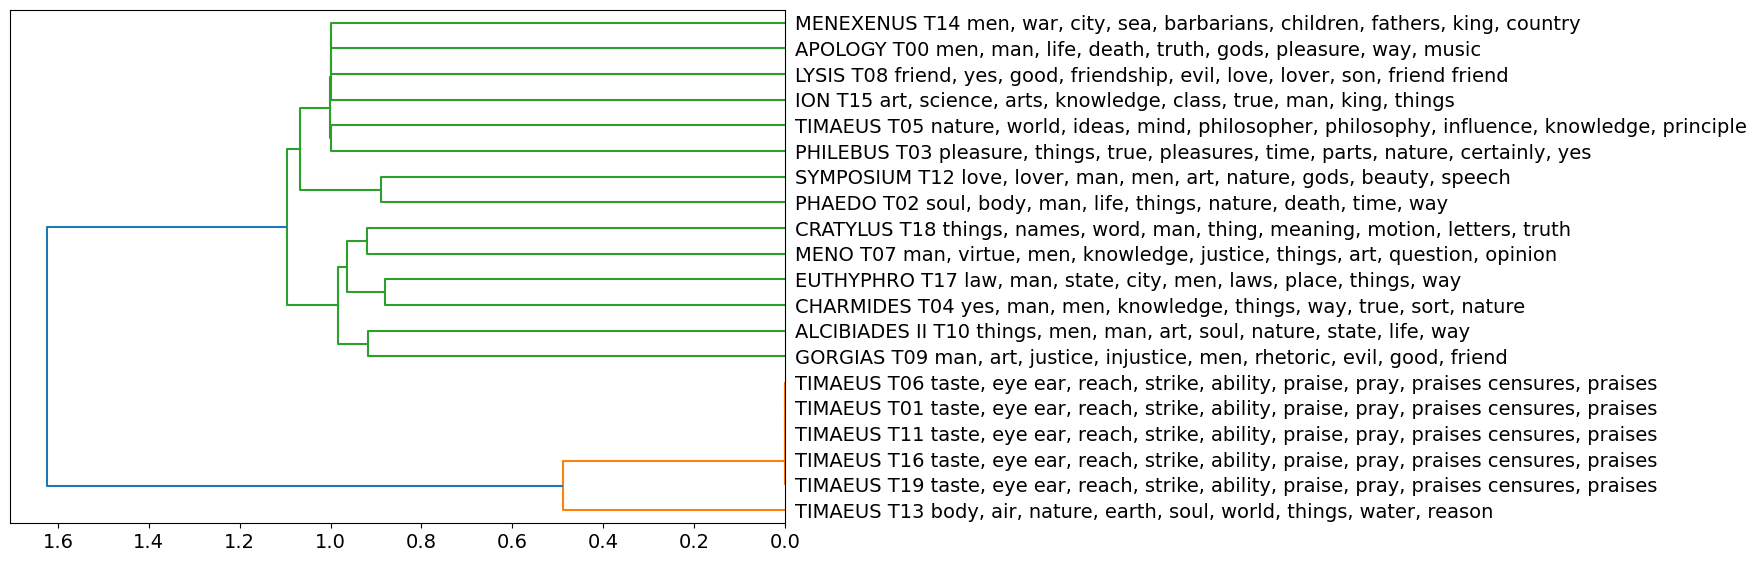

In [21]:
HAC(THETA.T, labels=labels).plot();

Running PCA on the topics -

<Figure size 640x480 with 0 Axes>

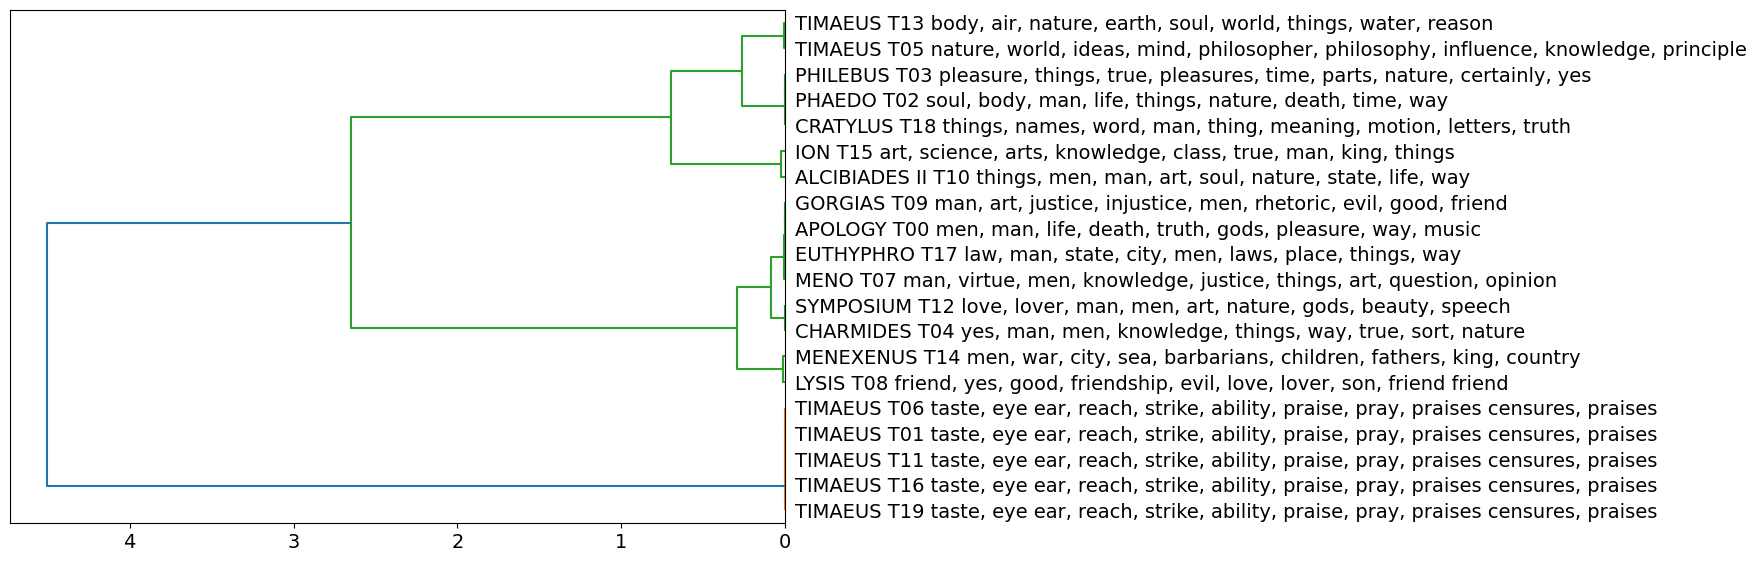

In [22]:
pca_engine_phi = PCA(2)
PHI_COMPS = pd.DataFrame(pca_engine_phi.fit_transform(normalize(PHI, norm='l2', axis=1)), index=PHI.index)
HAC(PHI_COMPS, labels=labels).plot()

<Figure size 640x480 with 0 Axes>

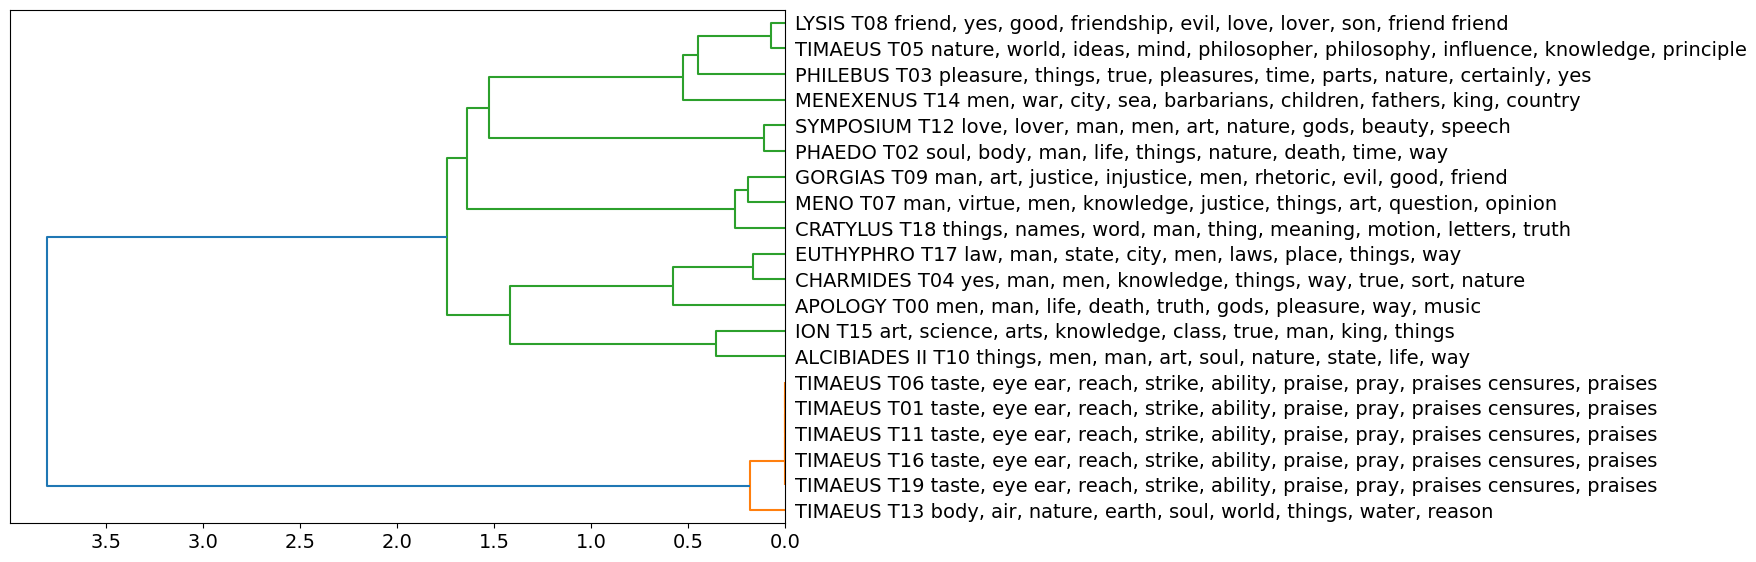

In [23]:
pca_engine_theta = PCA(5)
THETA_COMPS = pd.DataFrame(pca_engine_theta.fit_transform(normalize(THETA.T.values, norm='l2', axis=1)), index=THETA.T.index)
THETA_COMPS.index.name = 'topic_id'
HAC(THETA_COMPS, labels=labels).plot()

Examining how much the top two principal components contribute to the variance of each topic

In [24]:
px.scatter(THETA_COMPS.reset_index(), 0, 1, 
           size=TOPICS.doc_weight_sum, 
           color=TOPICS.title, 
           text='topic_id', 
           hover_name=TOPICS.label, 
           height=600, width=700)

In [25]:
px.scatter(PHI_COMPS.reset_index(), 0, 1, 
           size=TOPICS.term_freq, 
           color=TOPICS.title, 
           text='topic_id', hover_name=TOPICS.label, height=600, width=700)

In [26]:
PHI_LOADINGS = pd.DataFrame(pca_engine_phi.components_.T * np.sqrt(pca_engine_phi.explained_variance_), index=PHI.T.index)
PHI_LOADINGS.index.name = 'term_str'
px.scatter(PHI_LOADINGS.reset_index(), 0, 1, text='term_str', height=600, width=700)

In [27]:
THETA_LOADINGS = pd.DataFrame(pca_engine_theta.components_.T * np.sqrt(pca_engine_theta.explained_variance_), index=THETA.index)

In [28]:
doc['doc_label'] = doc.apply(lambda x: f"{LIB.loc[x.name[0]].raw_title}-{x.name[1]}", axis=1)
doc['book'] = doc.apply(lambda x: f"{LIB.loc[x.name[0]].raw_title}", axis=1)
doc['n_chars'] = doc.doc_str.str.len()

In [29]:
px.scatter(THETA_LOADINGS.reset_index(), 0, 1, 
           size=doc.n_chars,
           color=doc.book, height=600, width=900)

In [30]:
X = pd.concat([THETA.corr(method='kendall').stack().to_frame('corr_theta'), 
               PHI.T.corr(method='kendall').stack().to_frame('corr_phi')], axis=1)
X.index.names = ['topic_id_x','topic_id_y']
X = X.query("topic_id_x < topic_id_y") 
X['corr_mean'] = (X.corr_theta + X.corr_phi) / 2
X = X.reset_index()
X['label_x'] = X.topic_id_x.map(TOPICS.label)
X['label_y'] = X.topic_id_y.map(TOPICS.label)
X = X.set_index(['topic_id_x','topic_id_y'])
X

corr_theta  corr_phi  corr_mean  \
topic_id_x topic_id_y                                    
T00        T01           0.811688  0.013347   0.412518   
           T02           0.457143  0.220842   0.338992   
           T03           0.444156  0.113181   0.278668   
           T04           0.293506  0.314324   0.303915   
           T05           0.788312  0.099900   0.444106   
...                           ...       ...        ...   
T16        T18           0.507792  0.006982   0.257387   
           T19           1.000000  1.000000   1.000000   
T17        T18           0.301299  0.223556   0.262428   
           T19           0.435065  0.009887   0.222476   
T18        T19           0.507792  0.006982   0.257387   

                                                                 label_x  \
topic_id_x topic_id_y                                                      
T00        T01         T00 men, man, life, death, truth, gods, pleasu...   
           T02         T00 men, man, life, death, truth, gods, pleasu...   
           T03         T00 men, man, life, death, truth, gods, pleasu...   
           T04         T00 men, man, life, death, truth, gods, pleasu...   
           T05         T00 men, man, life, death, truth, gods, pleasu...   
...                                                                  ...   
T16        T18         T16 taste, eye ear, reach, strike, ability, pr...   
           T19         T16 taste, eye ear, reach, strike, ability, pr...   
T17        T18         T17 law, man, state, city, men, laws, place, t...   
           T19         T17 law, man, state, city, men, laws, place, t...   
T18        T19         T18 things, names, word, man, thing, meaning, ...   

                                                                 label_y  
topic_id_x topic_id_y                                                     
T00        T01         T01 taste, eye ear, reach, strike, ability, pr...  
           T02         T02 soul, body, man, life, things, nature, dea...  
           T03         T03 pleasure, things, true, pleasures, time, p...  
           T04         T04 yes, man, men, knowledge, things, way, tru...  
           T05         T05 nature, world, ideas, mind, philosopher, p...  
...                                                                  ...  
T16        T18         T18 things, names, word, man, thing, meaning, ...  
           T19         T19 taste, eye ear, reach, strike, ability, pr...  
T17        T18         T18 things, names, word, man, thing, meaning, ...  
           T19         T19 taste, eye ear, reach, strike, ability, pr...  
T18        T19         T19 taste, eye ear, reach, strike, ability, pr...  

[190 rows x 5 columns]

### Examining correlations between the topics

In [31]:
px.scatter(X, 'corr_phi', 'corr_theta', hover_data=['label_x', 'label_y'], width=600, height=1000)

In [32]:
X.sort_values('corr_phi', ascending=False)[['corr_phi', 'label_x','label_y']]

corr_phi  \
topic_id_x topic_id_y             
T11        T19         1.000000   
T01        T16         1.000000   
           T19         1.000000   
           T11         1.000000   
           T06         1.000000   
...                         ...   
T14        T19        -0.022199   
T11        T14        -0.022199   
T14        T16        -0.022199   
T06        T14        -0.022199   
T01        T14        -0.022199   

                                                                 label_x  \
topic_id_x topic_id_y                                                      
T11        T19         T11 taste, eye ear, reach, strike, ability, pr...   
T01        T16         T01 taste, eye ear, reach, strike, ability, pr...   
           T19         T01 taste, eye ear, reach, strike, ability, pr...   
           T11         T01 taste, eye ear, reach, strike, ability, pr...   
           T06         T01 taste, eye ear, reach, strike, ability, pr...   
...                                                                  ...   
T14        T19         T14 men, war, city, sea, barbarians, children,...   
T11        T14         T11 taste, eye ear, reach, strike, ability, pr...   
T14        T16         T14 men, war, city, sea, barbarians, children,...   
T06        T14         T06 taste, eye ear, reach, strike, ability, pr...   
T01        T14         T01 taste, eye ear, reach, strike, ability, pr...   

                                                                 label_y  
topic_id_x topic_id_y                                                     
T11        T19         T19 taste, eye ear, reach, strike, ability, pr...  
T01        T16         T16 taste, eye ear, reach, strike, ability, pr...  
           T19         T19 taste, eye ear, reach, strike, ability, pr...  
           T11         T11 taste, eye ear, reach, strike, ability, pr...  
           T06         T06 taste, eye ear, reach, strike, ability, pr...  
...                                                                  ...  
T14        T19         T19 taste, eye ear, reach, strike, ability, pr...  
T11        T14         T14 men, war, city, sea, barbarians, children,...  
T14        T16         T16 taste, eye ear, reach, strike, ability, pr...  
T06        T14         T14 men, war, city, sea, barbarians, children,...  
T01        T14         T14 men, war, city, sea, barbarians, children,...  

[190 rows x 3 columns]

In [33]:
X.sort_values('corr_phi', ascending=True)[['corr_phi', 'label_x','label_y']]

corr_phi  \
topic_id_x topic_id_y             
T14        T19        -0.022199   
           T16        -0.022199   
T01        T14        -0.022199   
T06        T14        -0.022199   
T11        T14        -0.022199   
...                         ...   
T01        T19         1.000000   
T16        T19         1.000000   
T11        T19         1.000000   
T06        T11         1.000000   
T01        T06         1.000000   

                                                                 label_x  \
topic_id_x topic_id_y                                                      
T14        T19         T14 men, war, city, sea, barbarians, children,...   
           T16         T14 men, war, city, sea, barbarians, children,...   
T01        T14         T01 taste, eye ear, reach, strike, ability, pr...   
T06        T14         T06 taste, eye ear, reach, strike, ability, pr...   
T11        T14         T11 taste, eye ear, reach, strike, ability, pr...   
...                                                                  ...   
T01        T19         T01 taste, eye ear, reach, strike, ability, pr...   
T16        T19         T16 taste, eye ear, reach, strike, ability, pr...   
T11        T19         T11 taste, eye ear, reach, strike, ability, pr...   
T06        T11         T06 taste, eye ear, reach, strike, ability, pr...   
T01        T06         T01 taste, eye ear, reach, strike, ability, pr...   

                                                                 label_y  
topic_id_x topic_id_y                                                     
T14        T19         T19 taste, eye ear, reach, strike, ability, pr...  
           T16         T16 taste, eye ear, reach, strike, ability, pr...  
T01        T14         T14 men, war, city, sea, barbarians, children,...  
T06        T14         T14 men, war, city, sea, barbarians, children,...  
T11        T14         T14 men, war, city, sea, barbarians, children,...  
...                                                                  ...  
T01        T19         T19 taste, eye ear, reach, strike, ability, pr...  
T16        T19         T19 taste, eye ear, reach, strike, ability, pr...  
T11        T19         T19 taste, eye ear, reach, strike, ability, pr...  
T06        T11         T11 taste, eye ear, reach, strike, ability, pr...  
T01        T06         T06 taste, eye ear, reach, strike, ability, pr...  

[190 rows x 3 columns]

### Introducing gravity to the topics

In [34]:
dist_metric = 'cityblock'
# dist_metric = 'cosine'
# dist_metric = 'jensenshannon'
X['dist_theta'] = pdist(THETA.T, dist_metric)
X['dist_phi'] = pdist(PHI, dist_metric)

In [35]:
X = X.reset_index()
X['weight_x'] = X.topic_id_x.map(TOPICS.doc_weight_sum)
X['weight_y'] = X.topic_id_y.map(TOPICS.doc_weight_sum)
X['gravity'] = X.weight_x * X.weight_y / X.dist_theta**2
X = X.set_index(['topic_id_x','topic_id_y'])

In [36]:
px.scatter(X, 'dist_theta', 'dist_phi', title=dist_metric, size='gravity', width=500, height=500, hover_data=['label_x','label_y'])

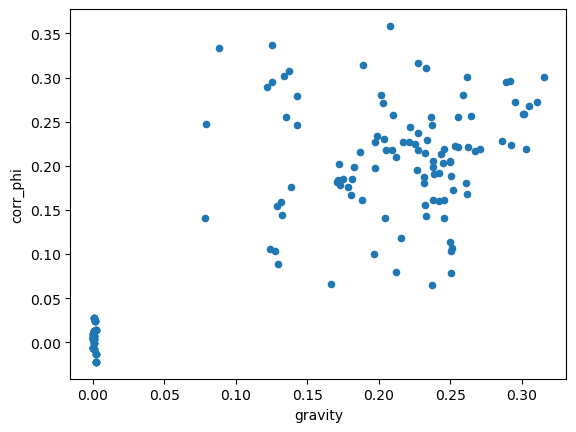

In [37]:
X.plot.scatter('gravity','corr_phi');

### Making graphs

In [38]:
TOPICS['short_label'] = TOPICS.label.apply(lambda x: x.split()[0] + r"\n" + " ".join(x.split(", ")[1:4]) + r"\n" + " ".join(x.split(", ")[4:8]) )

In [39]:
THETA2 = THETA[THETA >= weight_thresh].stack().to_frame('topic_weight').reset_index()

TOPICS['p'] = THETA2.topic_id.value_counts(normalize=True)

TPAIRS = THETA2.merge(THETA2, on=CHAP).value_counts(['topic_id_x', 'topic_id_y']).to_frame('n').query("topic_id_x < topic_id_y")
TPAIRS = TPAIRS.sort_index().reset_index()

TPAIRS['p_xy'] = TPAIRS.n / TPAIRS.n.sum()
TPAIRS['p_x'] = TPAIRS.topic_id_x.map(TOPICS.p)
TPAIRS['p_y'] = TPAIRS.topic_id_y.map(TOPICS.p)
TPAIRS['p_yGx'] = TPAIRS.p_xy / TPAIRS.p_x
TPAIRS['p_xGy'] = TPAIRS.p_xy / TPAIRS.p_y
TPAIRS['pwmi'] = np.log2(TPAIRS.p_xy / (TPAIRS.p_x * TPAIRS.p_y))
TPAIRS['mi'] = TPAIRS.pwmi * TPAIRS.p_xy
TPAIRS['nmi'] = TPAIRS.pwmi / np.log2(1/TPAIRS.p_xy) # Normalized point-wise mutual information (Bouma 2009) https://svn.spraakdata.gu.se/repos/gerlof/pub/www/Docs/npmi-pfd.pdf 

TPAIRS = TPAIRS.set_index(['topic_id_x', 'topic_id_y'])
TPAIRS = TPAIRS.join(X)

In [40]:
EDGES = []

# By correlation
EDGES.append(TPAIRS[TPAIRS.corr_phi > corr_thresh].index.to_list())

# By mutual information
EDGES.append(TPAIRS[TPAIRS.nmi > nmi_thresh].index.to_list())

# By both
EDGES.append(TPAIRS[(TPAIRS.corr_phi > corr_thresh) & (TPAIRS.nmi > nmi_thresh)].index.to_list())

In [41]:
px.scatter(TPAIRS.reset_index(), 'nmi', 'corr_phi', 
           hover_data=['label_x','label_y'],
           size='gravity', 
           color='p_xy', marginal_x='histogram', marginal_y='histogram',
           height=800, width=1000, 
           log_x=False, log_y=False)

In [42]:
def draw_graph(edge_num = 0):
    G = Graph('tm', node_attr={'shape':'rectangle'})
    NODES = set()
    for src, dst in EDGES[edge_num]:
        NODES.add(src)
        NODES.add(dst)
        G.edge(src, dst)
    for node in sorted(NODES):
        G.node(node, TOPICS.loc[node].short_label)
    G.view(f"tm{edge_num}")

In [43]:
draw_graph(0)
draw_graph(1)
draw_graph(2)

### Outputting tables

In [44]:
doc.to_csv(f'{data_out}/{data_prefix}-DOCS-CHAP.csv')
TOPICS.to_csv(f'{data_out}/{data_prefix}-TOPICS-CHAP.csv')
PHI.to_csv(f'{data_out}/{data_prefix}-PHI-CHAP.csv')
THETA.to_csv(f'{data_out}/{data_prefix}-THETA-CHAP.csv')